# Example 01. Gridding of the scan data

This example generates grids in spherical and scan coordinate systems. Aside from simply visualizing your scan and exporting them to a GEDI ready format, these also allow you to checks for atrefacts and azimuth/zenith angles range to use in the estimation of vertical plant profiles.

## Load all the required modules

In [23]:
import os
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

from riegl_canopy import riegl_io, grid

## Some plotting functions

In [61]:
def plot_riegl_grid(data, label='Range (m)', clim=[0,30], figsize=(16,10), nbins=10,
                    cmap='bone', nreturns=None, extend='max', nodata=-9999, spherical=False):
    """Example function to plot a RIEGL grid"""
    if nreturns is None:
        nreturns = data.shape[0]
    fig, ax = plt.subplots(ncols=1, nrows=nreturns, squeeze=False, 
                           sharex=True, sharey=True, figsize=figsize)
    with plt.style.context('seaborn-notebook'):
        for i in range(nreturns):  
            ax[i,0].set_facecolor('white')
            ax[i,0].set(adjustable='box', aspect='equal')
            if spherical:
                extent = [0,360,180,0]
                ax[i,0].set(xlabel='Azimuth', ylabel='Zenith')
            else:
                ax[i,0].get_xaxis().set_visible(False)
                ax[i,0].get_yaxis().set_visible(False)
                extent = None
            tmp = np.ma.masked_equal(data[i], nodata)
            p = ax[i,0].imshow(tmp, interpolation='nearest', clim=clim, 
                               cmap=matplotlib.cm.get_cmap(cmap,nbins),  
                               vmin=clim[0], vmax=clim[1], extent=extent)
            divider = make_axes_locatable(ax[i,0])
            cax = divider.append_axes('right', size='2%', pad=0.05)
            cbar = fig.colorbar(p, label=label, cax=cax, extend=extend)
            cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=nbins))
    fig.tight_layout()
    plt.show()


## Identify all of the input files

If you are using a RIEGL VZ400 scanner or used a pulse rate <= 300khz, then you only need the RXP files for point cloud data.

In [51]:
os.chdir('/gpfs/data1/vclgp/data/tls_point_clouds/riegl_registered/maeda_Amazon_Dimona-100ha-SOUTH.RiSCAN')

# Upright scan files
upright_rxp_fn = 'SCANS/ScanPos001/SINGLESCANS/190426_112319.rxp'
upright_rdbx_fn = 'project.rdb/SCANS/ScanPos001/SINGLESCANS/190426_112319/190426_112319.rdbx'
upright_transform_fn = 'project.rdb/SCANS/ScanPos001.DAT'

# Tilt scan files
tilt_rxp_fn = 'SCANS/ScanPos002/SINGLESCANS/190426_112552.rxp'
tilt_rdbx_fn = 'project.rdb/SCANS/ScanPos002/SINGLESCANS/190426_112552/190426_112552.rdbx'
tilt_transform_fn = 'project.rdb/SCANS/ScanPos002.DAT'

## Grid and visualize the scan data

### RDBX point data in the scan coordinate system

In [29]:
upright_reflectance_grid = grid.grid_rdbx_scan(upright_rdbx_fn, attribute='reflectance')

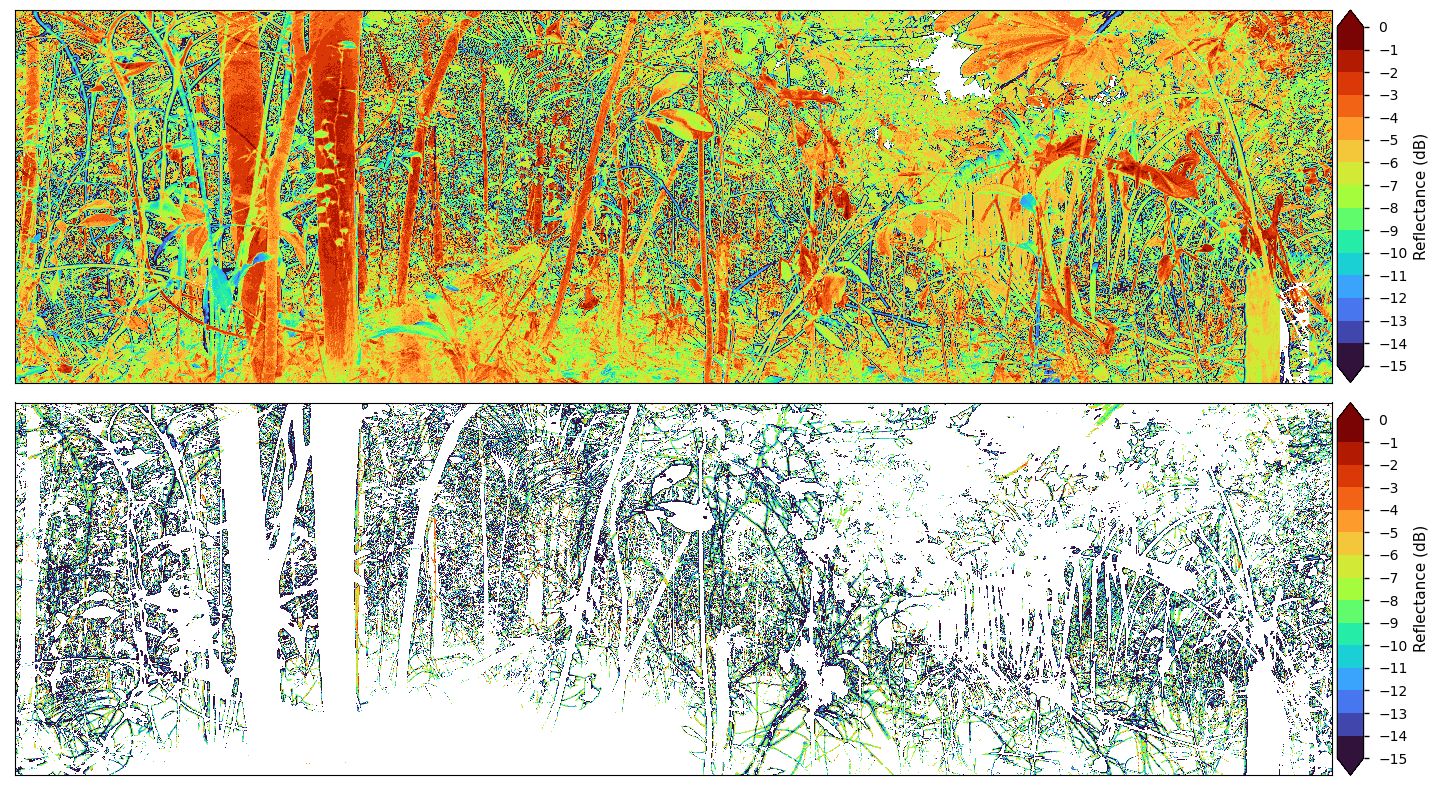

In [31]:
plot_riegl_grid(upright_reflectance_grid, label='Reflectance (dB)', nreturns=2, clim=[-15,0],
                figsize=(16,8), nbins=15, cmap='turbo', extend='both')

In [32]:
tilt_reflectance_grid = grid.grid_rdbx_scan(tilt_rdbx_fn, attribute='reflectance')

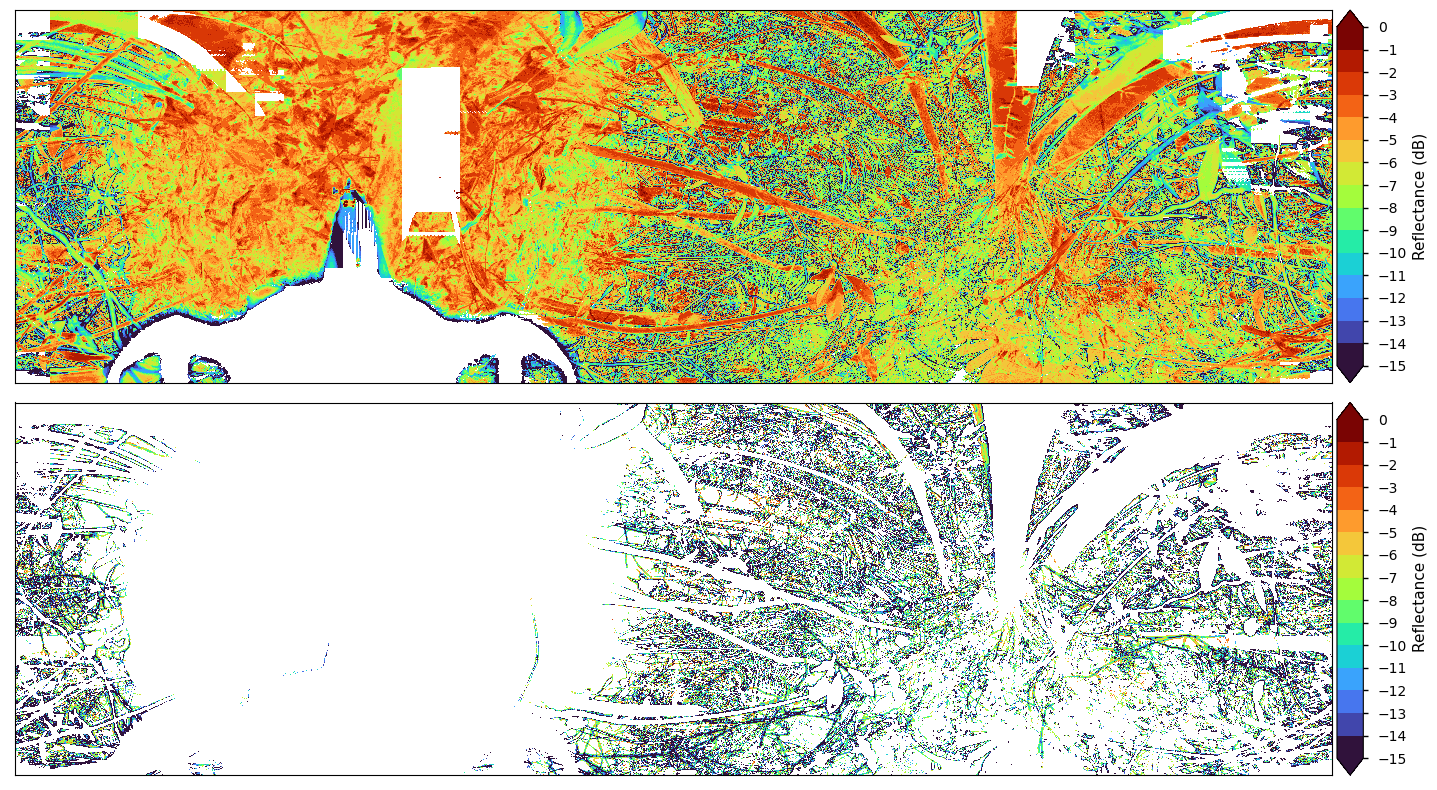

In [57]:
plot_riegl_grid(tilt_reflectance_grid, label='Reflectance (dB)', nreturns=2, clim=[-15,0],
                figsize=(16,8), nbins=15, cmap='turbo', extend='both')

### RXP pulse data in the scan coordinate system

In [35]:
upright_count_grid = grid.grid_rxp_scan(upright_rxp_fn, attribute='target_count')

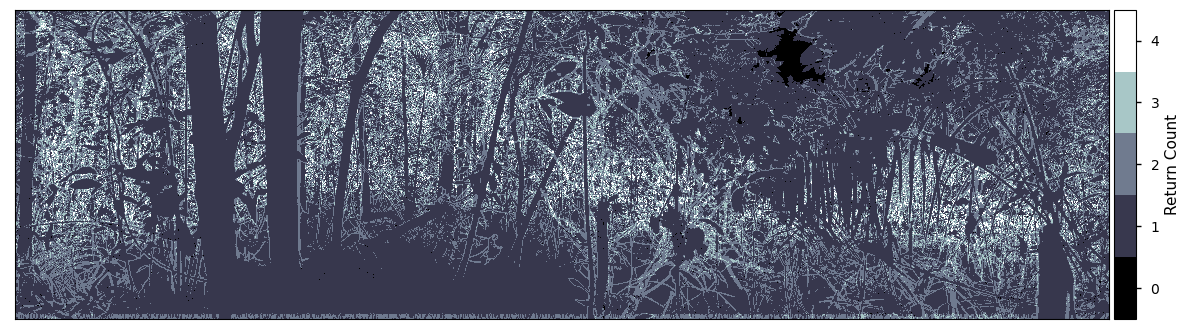

In [62]:
plot_riegl_grid(upright_count_grid, label='Return Count', clim=[-0.5,4.5], figsize=(12,8), 
                nbins=5, cmap='bone', extend='neither')

### RDBX point data in the spherical coordinate system used for vertical profiles

In [43]:
upright_range_grid = grid.grid_rdbx_spherical(upright_rdbx_fn, upright_transform_fn, 0.1, attribute='range', first_only=True)

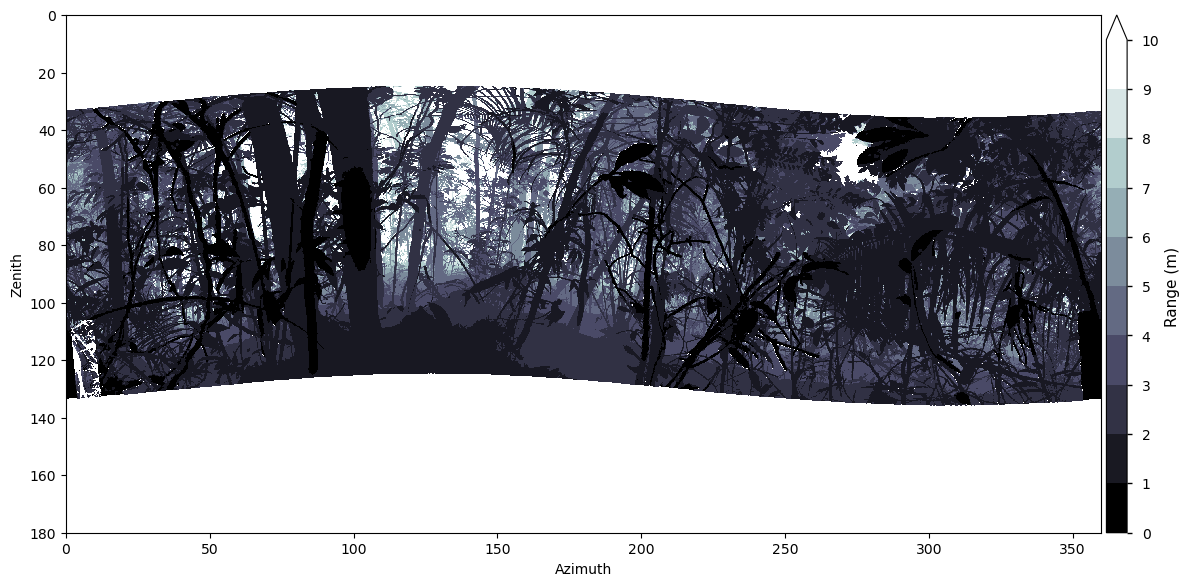

In [58]:
plot_riegl_grid(upright_range_grid, label='Range (m)', clim=[0,10], figsize=(12,8), nbins=10, cmap='bone', spherical=True)

In [45]:
tilt_range_grid = grid.grid_rdbx_spherical(tilt_rdbx_fn, tilt_transform_fn, 0.1, attribute='range', first_only=True)

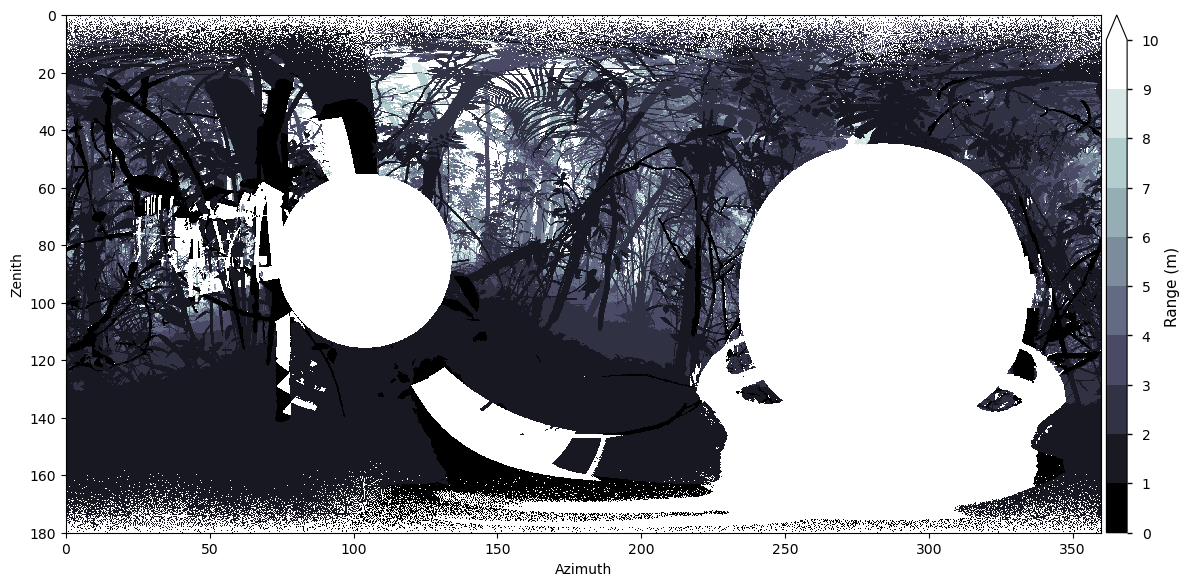

In [59]:
plot_riegl_grid(tilt_range_grid, label='Range (m)', clim=[0,10], figsize=(12,8), nbins=10, cmap='bone', spherical=True)

### RXP pulse data in the spherical coordinate system used for vertical profiles

In [47]:
upright_zenith_grid = grid.grid_rxp_spherical(upright_rxp_fn, upright_transform_fn, 0.1, attribute='zenith')

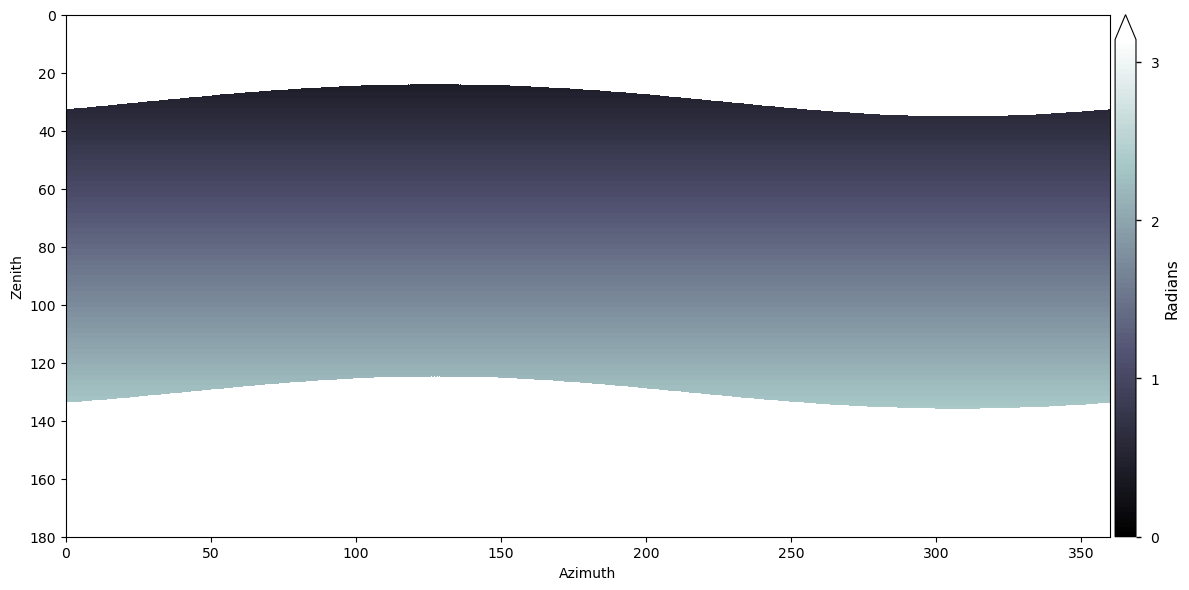

In [48]:
plot_riegl_grid(upright_zenith_grid, label='Radians', clim=[0,np.pi], figsize=(12,8), nbins=100, cmap='bone', spherical=True)

In [49]:
tilt_zenith_grid = grid.grid_rxp_spherical(tilt_rxp_fn, tilt_transform_fn, 0.1, attribute='zenith')

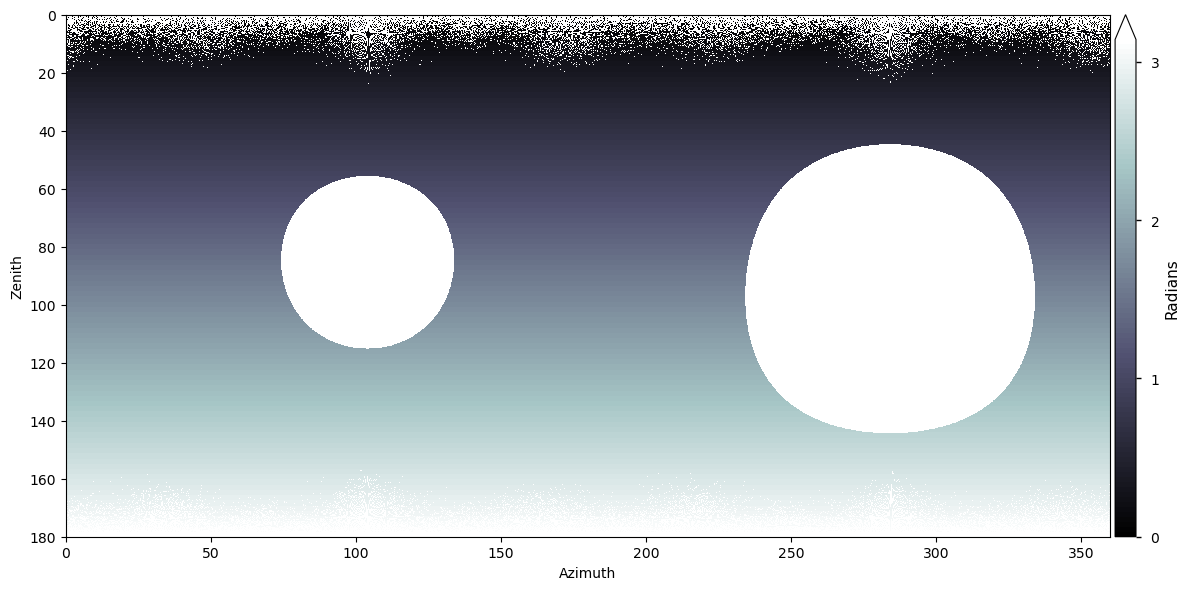

In [50]:
plot_riegl_grid(tilt_zenith_grid, label='Radians', clim=[0,np.pi], figsize=(12,8), nbins=100, cmap='bone', spherical=True)